# Part-1 - Parsing the webpage and creating a DataFrame

### Importing all the required libraries

Using Beautiful soup, I will be parsing the Wikipedia page containing the List of all the Postal Codes of Canada:M .
I will then create a dataframe with that list, and perform basic preprocessing. At the end I will save the dataframe as a CSV to import it for Part-2 of the HW

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from lxml import etree
import requests

### Using Beautiful soup to parse the Wikipedia HTML page and converting it to a List

In [2]:
urls = r"https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
response = requests.get(urls, headers=headers, timeout=0.2)
soup = BeautifulSoup(response.text)


data = []


table = soup.find('table')
table_body = table.find('tbody')
rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

### Displaying the List


In [3]:
data

[[],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned'],
 ['M8A', 'Not assigned', 'Not assigned'],
 ['M9A', 'Etobicoke', 'Islington Avenue'],
 ['M1B', 'Scarborough', 'Rouge'],
 ['M1B', 'Scarborough', 'Malvern'],
 ['M2B', 'Not assigned', 'Not assigned'],
 ['M3B', 'North York', 'Don Mills North'],
 ['M4B', 'East York', 'Woodbine Gardens'],
 ['M4B', 'East York', 'Parkview Hill'],
 ['M5B', 'Downtown Toronto', 'Ryerson'],
 ['M5B', 'Downtown Toronto', 'Garden District'],
 ['M6B', 'North York', 'Glencairn'],
 ['M7B', 'Not assigned', 'Not assigned'],
 ['M8B', 'Not assigned', 'Not assigned'],
 ['M9B', 'Etobicoke', 'Cloverdale'],
 ['M9B', 'Etobicoke', 'Islington'],
 ['M

### Converting the List to a Dataframe and performing initial processing to rename columns, dropping the 0th index and removing rows without an assigned borough

In [4]:
Canada = pd.DataFrame(data)
Canada = pd.DataFrame(data).drop(0, axis =0)
Canada.columns=['PostalCode','Borough','Neighborhood']
Canada.reset_index(inplace =True)
Canada = Canada.drop('index', axis =1)
Canada= Canada[Canada.Borough != 'Not assigned']



### Viewing the Dataframe

In [5]:
Canada.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Merging the Neighborhoods using Groupby

In [6]:
Canada = Canada.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
Canada.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Assigning Not assigned neighborhoods to the borough.

In [7]:
Canada.loc[Canada['Neighborhood'] == 'Not assigned', ['Neighborhood']] = Canada['Borough']
Canada.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Printing the Shape of the DataFrame

In [8]:
Canada.shape

(103, 3)

### Saving the DataFrame to a CSV

In [9]:
Canada.to_csv('Canada.csv' , index=False)

# Part-2 Getting the Latitude and Longitude of the Data using Geospatial Coordinates

### Importing all the required libraries

In [13]:
import numpy as np
import pandas as pd


### I will be importing the Canada.csv which I saved during Part-1. I will then import another CSV 'Geospatial Coordinates' which contains the latitude and longitude of the post codes

In [14]:
Canada = pd.read_csv('Canada.csv')
Canada.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Importing the provided Geospatial Coordinates as a DataFrame


In [15]:
postalCode = pd.read_csv('Geospatial_Coordinates.csv')
postalCode.columns=['PostalCode','Latitude','Longitude']

In [16]:
postalCode.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging the above dataframe with our original Canada Dataframe using the PostalCode to create a new DataFrame with the location coordinates

In [17]:
finalDF = pd.merge(Canada, postalCode, on='PostalCode')
finalDF.head()
finalDF.shape

(103, 5)

### Saving this new dataframe as a CSV so we can import it in Part-3 of the HW

In [18]:
finalDF.to_csv('finalDF.csv' , index=False)

# Part-3  Segmenting and Clustering the Neighborhoods in Toronto

 In this part, I will be importing the previously created DataFrame with the lat and Long coordinates.
 I will then fitler the dataframe to only contain the Boroughs in Toronto. Finally I will be performing Segmenting and Clustering Operations using the Four Square API

### Importing all the required libraries

In [19]:
import pandas as pd
import numpy as np
import folium
from geopy.geocoders import Nominatim
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans


In [20]:
finalDF = pd.read_csv('finalDF.csv')
finalDF.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Creating a new Dataframe with only the rows having a borough in Toronto

In [21]:
Toronto = finalDF[finalDF['Borough'].str.contains('Toronto')]
Toronto.shape

(38, 5)

In [22]:
Toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### Using the geolocator to get the geographical coordinates of Toronto

In [23]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


### Creatiing a Map of Toronto and displaying the lat/long coordinates from our dataframe, using Folium and the above coordinates

In [24]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
map_Toronto


Note: I have imported my Foursquare credentials then deleted the cell block to hide my credentials.

### Function to get the list of nearby venues using the FourSquare API

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting the nearby venues in Toronto

In [27]:
Toronto_venues = getNearbyVenues(names=Toronto['Neighborhood'],
                                   latitudes=Toronto['Latitude'],
                                   longitudes=Toronto['Longitude']
                                  )


The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [28]:
Toronto_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 7 columns):
Neighborhood              838 non-null object
Neighborhood Latitude     838 non-null float64
Neighborhood Longitude    838 non-null float64
Venue                     838 non-null object
Venue Latitude            838 non-null float64
Venue Longitude           838 non-null float64
Venue Category            838 non-null object
dtypes: float64(4), object(3)
memory usage: 45.9+ KB


In [30]:
restaurant_df= Toronto_venues[Toronto_venues['Venue Category'].str.contains('Restaurant')]
park_df= Toronto_venues[Toronto_venues['Venue Category'].str.contains('Park')]

In [33]:
restaurant_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
8,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant
9,"The Danforth West, Riverdale",43.679557,-79.352188,Messini Authentic Gyros,43.677827,-79.350569,Greek Restaurant
10,"The Danforth West, Riverdale",43.679557,-79.352188,Mezes,43.677962,-79.350196,Greek Restaurant
11,"The Danforth West, Riverdale",43.679557,-79.352188,Christina's On The Danforth,43.678240,-79.349185,Greek Restaurant


In [34]:
park_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
40,"The Beaches West, India Bazaar",43.668999,-79.315572,Woodbine Park,43.664860,-79.315109,Park
52,"The Beaches West, India Bazaar",43.668999,-79.315572,Measurement Park,43.666916,-79.312631,Park
79,Studio District,43.659526,-79.340923,Jimmie Simpson Park,43.659230,-79.345063,Park
83,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
86,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


In [36]:
print(Toronto_venues.shape)
Toronto_venues.head(20)

(838, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
3,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
5,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
6,"The Danforth West, Riverdale",43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop
7,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop
8,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant
9,"The Danforth West, Riverdale",43.679557,-79.352188,Messini Authentic Gyros,43.677827,-79.350569,Greek Restaurant


In [40]:
venueCategory_count = Toronto_venues.groupby('Venue Category').count()

In [43]:
venueCategory_count.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Airport,1,1,1,1,1,1
Airport Food Court,1,1,1,1,1,1
Airport Gate,1,1,1,1,1,1
Airport Lounge,2,2,2,2,2,2
Airport Service,2,2,2,2,2,2


In [44]:
Toronto_venues['Neighborhood'].value_counts()

Stn A PO Boxes 25 The Esplanade                                                                               30
Central Bay Street                                                                                            30
Harbourfront, Regent Park                                                                                     30
Berczy Park                                                                                                   30
Cabbagetown, St. James Town                                                                                   30
Studio District                                                                                               30
Adelaide, King, Richmond                                                                                      30
Harbord, University of Toronto                                                                                30
The Danforth West, Riverdale                                                                    

### Grouping by the Neighborhoods

In [45]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",30,30,30,30,30,30
Berczy Park,30,30,30,30,30,30
"Brockton, Exhibition Place, Parkdale Village",21,21,21,21,21,21
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",30,30,30,30,30,30
Central Bay Street,30,30,30,30,30,30
"Chinatown, Grange Park, Kensington Market",30,30,30,30,30,30
Christie,15,15,15,15,15,15


### Checking the number of unique categories

In [46]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 190 uniques categories.


### Using the get_dummies method to perform binary encoding on the data

In [47]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head(20)

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Grouping by the Neighborhood

In [48]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.066667,0.033333,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333


### Determining the Frequency of Top 10 Venues

In [51]:
num_top_venues = 10

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0           Steakhouse  0.10
1                Hotel  0.07
2     Asian Restaurant  0.07
3                 Café  0.07
4                  Bar  0.03
5               Lounge  0.03
6          Pizza Place  0.03
7           Smoke Shop  0.03
8           Food Court  0.03
9  Monument / Landmark  0.03


----Berczy Park----
                venue  freq
0              Bakery  0.07
1  Seafood Restaurant  0.07
2        Cocktail Bar  0.07
3                Café  0.07
4      Farmers Market  0.07
5        Liquor Store  0.03
6              Museum  0.03
7   French Restaurant  0.03
8         Fish Market  0.03
9      Clothing Store  0.03


----Brockton, Exhibition Place, Parkdale Village----
                    venue  freq
0          Breakfast Spot  0.10
1                    Café  0.10
2             Coffee Shop  0.10
3            Climbing Gym  0.05
4              Restaurant  0.05
5    Caribbean Restaurant  0.05
6                 Stadium  0.05
7  Furn

Function to determine the most common venues

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Determining the Top 10 Venues

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Steakhouse,Hotel,Asian Restaurant,Café,General Travel,Monument / Landmark,Bar,Speakeasy,Plaza,Lounge
1,Berczy Park,Café,Seafood Restaurant,Farmers Market,Cocktail Bar,Bakery,Steakhouse,Breakfast Spot,Liquor Store,Concert Hall,Belgian Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Breakfast Spot,Café,Climbing Gym,Bar,Burrito Place,Restaurant,Caribbean Restaurant,Pet Store,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Spa,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Butcher
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Terminal,Airport Lounge,Airport Service,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport


### Creating a Cluster group using K-Means

In [54]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)


In [55]:
Toronto_grouped_clustering.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### Calculating the optimal K-Value using the Elbow Method

In [56]:

from sklearn.cluster import KMeans
wcss = [ ] #Within Cluster sum of squares

for i in range(1,6):
    kmeans= KMeans(n_clusters=i,random_state=0,init='k-means++')
    kmeans.fit(Toronto_grouped_clustering)
    wcss.append(kmeans.inertia_)
 

In [57]:
Toronto_grouped_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Columns: 189 entries, Yoga Studio to Wings Joint
dtypes: float64(189)
memory usage: 56.2 KB


In [59]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'wcss(Error)')

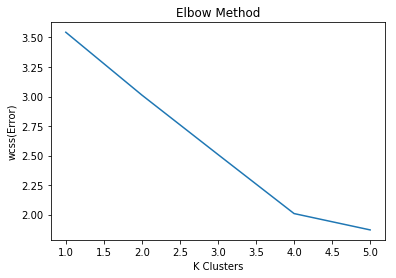

In [60]:
plt.plot(range(1,6) , wcss)
plt.title('Elbow Method')
plt.xlabel('K Clusters')
plt.ylabel('wcss(Error)')

### Calculating the optimal K-Value using Dendrogram

Text(0, 0.5, 'Euclidean Distance')

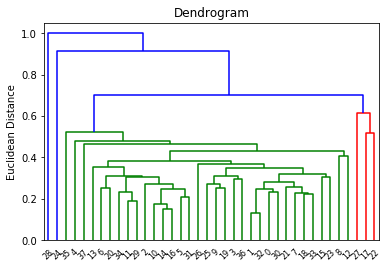

In [63]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(Toronto_grouped_clustering, method='complete'))
plt.title('Dendrogram')
plt.ylabel('Euclidean Distance')

In [64]:
# set number of clusters
kclusters = 3

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [65]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Coffee Shop,Health Food Store,Trail,Pub,Wings Joint,Dance Studio,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Ice Cream Shop,Italian Restaurant,Brewery,Bookstore,Restaurant,Spa,Juice Bar,Diner,Dessert Shop
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,2,Park,Ice Cream Shop,Pub,Brewery,Sandwich Place,Burger Joint,Burrito Place,Fast Food Restaurant,Fish & Chips Shop,Italian Restaurant
43,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,American Restaurant,Bakery,Italian Restaurant,Comfort Food Restaurant,Cheese Shop,Bookstore,Sandwich Place,Juice Bar
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Bus Line,Park,Swim School,Dance Studio,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run,Discount Store,Diner


In [66]:
Toronto_merged.head(30)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Coffee Shop,Health Food Store,Trail,Pub,Wings Joint,Dance Studio,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Ice Cream Shop,Italian Restaurant,Brewery,Bookstore,Restaurant,Spa,Juice Bar,Diner,Dessert Shop
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,2,Park,Ice Cream Shop,Pub,Brewery,Sandwich Place,Burger Joint,Burrito Place,Fast Food Restaurant,Fish & Chips Shop,Italian Restaurant
43,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,American Restaurant,Bakery,Italian Restaurant,Comfort Food Restaurant,Cheese Shop,Bookstore,Sandwich Place,Juice Bar
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Bus Line,Park,Swim School,Dance Studio,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run,Discount Store,Diner
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197,2,Gym,Pizza Place,Grocery Store,Park,Breakfast Spot,Burger Joint,Hotel,Food & Drink Shop,Sandwich Place,Deli / Bodega
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,2,Coffee Shop,Sporting Goods Shop,Clothing Store,Shoe Store,Sandwich Place,Salon / Barbershop,Rental Car Location,Chinese Restaurant,Park,Yoga Studio
47,M4S,Central Toronto,Davisville,43.704324,-79.388790,2,Sandwich Place,Dessert Shop,Coffee Shop,Italian Restaurant,Café,Pizza Place,Sushi Restaurant,Pharmacy,Costume Shop,Brewery
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,1,Playground,Tennis Court,Cuban Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run,Discount Store,Diner,Dessert Shop
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,2,Coffee Shop,Pub,Pizza Place,Fried Chicken Joint,Medical Center,Sports Bar,Bagel Shop,Supermarket,Sushi Restaurant,Light Rail Station


### Creating a Map using Folium to visualize the Clusters

In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining some of the Clusters

In [68]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,0,Bus Line,Park,Swim School,Dance Studio,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run,Discount Store,Diner
50,Downtown Toronto,0,Park,Playground,Trail,Wings Joint,Cuban Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run,Discount Store
64,Central Toronto,0,Bus Line,Park,Trail,Jewelry Store,Sushi Restaurant,Dance Studio,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run


In [69]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,1,Playground,Tennis Court,Cuban Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run,Discount Store,Diner,Dessert Shop
63,Central Toronto,1,Garden,Home Service,Dance Studio,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run,Discount Store,Diner


In [70]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,2,Coffee Shop,Health Food Store,Trail,Pub,Wings Joint,Dance Studio,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dog Run
41,East Toronto,2,Greek Restaurant,Ice Cream Shop,Italian Restaurant,Brewery,Bookstore,Restaurant,Spa,Juice Bar,Diner,Dessert Shop
42,East Toronto,2,Park,Ice Cream Shop,Pub,Brewery,Sandwich Place,Burger Joint,Burrito Place,Fast Food Restaurant,Fish & Chips Shop,Italian Restaurant
43,East Toronto,2,Café,Coffee Shop,American Restaurant,Bakery,Italian Restaurant,Comfort Food Restaurant,Cheese Shop,Bookstore,Sandwich Place,Juice Bar
45,Central Toronto,2,Gym,Pizza Place,Grocery Store,Park,Breakfast Spot,Burger Joint,Hotel,Food & Drink Shop,Sandwich Place,Deli / Bodega
46,Central Toronto,2,Coffee Shop,Sporting Goods Shop,Clothing Store,Shoe Store,Sandwich Place,Salon / Barbershop,Rental Car Location,Chinese Restaurant,Park,Yoga Studio
47,Central Toronto,2,Sandwich Place,Dessert Shop,Coffee Shop,Italian Restaurant,Café,Pizza Place,Sushi Restaurant,Pharmacy,Costume Shop,Brewery
49,Central Toronto,2,Coffee Shop,Pub,Pizza Place,Fried Chicken Joint,Medical Center,Sports Bar,Bagel Shop,Supermarket,Sushi Restaurant,Light Rail Station
51,Downtown Toronto,2,Restaurant,Coffee Shop,Café,Italian Restaurant,Gift Shop,Japanese Restaurant,Indian Restaurant,Pub,Bakery,Bank
52,Downtown Toronto,2,Gay Bar,Japanese Restaurant,Coffee Shop,Bubble Tea Shop,Salon / Barbershop,Burger Joint,Restaurant,Ramen Restaurant,Pub,Pizza Place


In [71]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
